# Task 2: Network Analysis with Louvain Clustering and PageRank


In [ ]:
!pip install python-louvain networkx matplotlib pandas

In [ ]:
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')

In [ ]:

with open('channel_data (1).json', 'r', encoding='utf-8') as f:
    channel_data = json.load(f)
channel_df = pd.DataFrame(channel_data)


rows = []
with open('video_data.json', 'r', encoding='utf-8') as f:
    for line in f:
        try:
            rows.append(json.loads(line))
        except Exception as e:
            print("Skipping line due to error:", e)
video_df = pd.DataFrame(rows)



with open('video_categories.json', 'r', encoding='utf-8') as f:
    cat_obj = json.load(f)
video_categories = cat_obj['items'] if 'items' in cat_obj else cat_obj
cat_df = pd.json_normalize(video_categories)
cat_df['id'] = cat_df['id'].astype(str)

print(f'Channels: {len(channel_df)}')
print(f'Videos: {len(video_df)}')
print(f'Video Categories: {len(cat_df)}')

Channels: 1561
Videos: 440772
Video Categories: 32


In [ ]:

print(f'Channels: {len(channel_df)}')
print(f'Videos: {len(video_df)}')
print(f'Video Categories: {len(cat_df)}')


Channels: 1561
Videos: 440772
Video Categories: 32


In [ ]:
cat_map = dict(zip(cat_df['id'], cat_df['snippet.title']))
video_df['category_name'] = video_df['category_id'].astype(str).map(cat_map).fillna('Unknown')


In [ ]:
edges = []
if {'channel_id', 'video_id'}.issubset(video_df.columns):
    channel_video = video_df[['channel_id', 'video_id']].dropna()
    channel_video.columns = ['source', 'target']
    channel_video['edge_type'] = 'channel_to_video'
    edges.append(channel_video)
    print(f"   - Channel→Video edges: {len(channel_video)}")

edges_df = pd.concat(edges, ignore_index=True)
print(f"\nTotal edges: {len(edges_df)}")

   - Channel→Video edges: 440772

Total edges: 440772


In [ ]:
G = nx.from_pandas_edgelist(edges_df, source='source', target='target', edge_attr='edge_type', create_using=nx.Graph())

print(f'Network Graph Statistics:')
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}')
print(f'Density: {nx.density(G):.6f}')
print(f'Connected Components: {nx.number_connected_components(G)}')

Network Graph Statistics:
Nodes: 616157
Edges: 440772
Density: 0.000002
Connected Components: 175385


In [ ]:
vid_cat = dict(zip(video_df['video_id'], video_df['category_name']))
nx.set_node_attributes(G, vid_cat, 'category')

In [ ]:
print('Computing PageRank Scores...')
pagerank_scores = nx.pagerank(G, alpha=0.85)
nx.set_node_attributes(G, pagerank_scores, 'pagerank')

print('\nTop 10 Most Influential Nodes (by PageRank):')
print('-' * 60)
top_nodes = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]
for i, (node, score) in enumerate(top_nodes, 1):
    node_type = 'Channel' if node in channel_df['channel_id'].values else 'Video' if node in video_df['video_id'].values else 'Other'
    cat = vid_cat[node] if node in vid_cat else ''
    print(f"{i:2d}. {node[:40]:40s} | {score:.6f} | {node_type} | {cat}")

Computing PageRank Scores...

Top 10 Most Influential Nodes (by PageRank):
------------------------------------------------------------
 1. UCXIJgqnII2ZOINSWNOGFThA                 | 0.001653 | Other | 
 2. UC3M7l8ved_rYQ45AVzS0RGA                 | 0.000838 | Other | 
 3. UCO0akufu9MOzyz3nvGIXAAw                 | 0.000827 | Channel | 
 4. UC_gUM8rL-Lrg6O3adPW9K1g                 | 0.000725 | Other | 
 5. UCpwvZwUam-URkxB7g4USKpg                 | 0.000670 | Other | 
 6. UCupvZG-5ko_eiXAupbDfxWw                 | 0.000637 | Other | 
 7. UCsT0YIqwnpJCM-mx7-gSA4Q                 | 0.000543 | Other | 
 8. UCaXkIU1QidjPwiAYu6GcHjg                 | 0.000492 | Other | 
 9. UCNye-wNBqNL5ZzHSJj3l8Bg                 | 0.000487 | Channel | 
10. UCgrNz-aDmcr2uuto8_DL2jg                 | 0.000431 | Other | 


In [ ]:
print('Detecting Communities (Louvain Algorithm)')
partition = community_louvain.best_partition(G, random_state=42)
nx.set_node_attributes(G, partition, 'community')

num_communities = len(set(partition.values()))
print(f'Number of communities detected: {num_communities}')
modularity = community_louvain.modularity(partition, G)
print(f'Modularity score: {modularity:.4f}')
community_sizes = pd.Series(list(partition.values())).value_counts().sort_index()
print(f'\nCommunity Size Distribution:')
for comm_id, size in community_sizes.items():
    print(f'   Community {comm_id}: {size} nodes')

Streaming output truncated to the last 5000 lines.
   Community 170385: 9 nodes
   Community 170386: 2 nodes
   Community 170387: 5 nodes
   Community 170388: 5 nodes
   Community 170389: 2 nodes
   Community 170390: 2 nodes
   Community 170391: 4 nodes
   Community 170392: 2 nodes
   Community 170393: 2 nodes
   Community 170394: 2 nodes
   Community 170395: 3 nodes
   Community 170396: 2 nodes
   Community 170397: 2 nodes
   Community 170398: 2 nodes
   Community 170399: 2 nodes
   Community 170400: 2 nodes
   Community 170401: 2 nodes
   Community 170402: 2 nodes
   Community 170403: 8 nodes
   Community 170404: 2 nodes
   Community 170405: 2 nodes
   Community 170406: 2 nodes
   Community 170407: 3 nodes
   Community 170408: 3 nodes
   Community 170409: 2 nodes
   Community 170410: 2 nodes
   Community 170411: 5 nodes
   Community 170412: 2 nodes
   Community 170413: 2 nodes
   Community 170414: 2 nodes
   Community 170415: 2 nodes
   Community 170416: 2 nodes
   Community 170417: 

Largest community: 29889 with 1374 nodes.
Sampled: 80 nodes for plotting (for clarity).


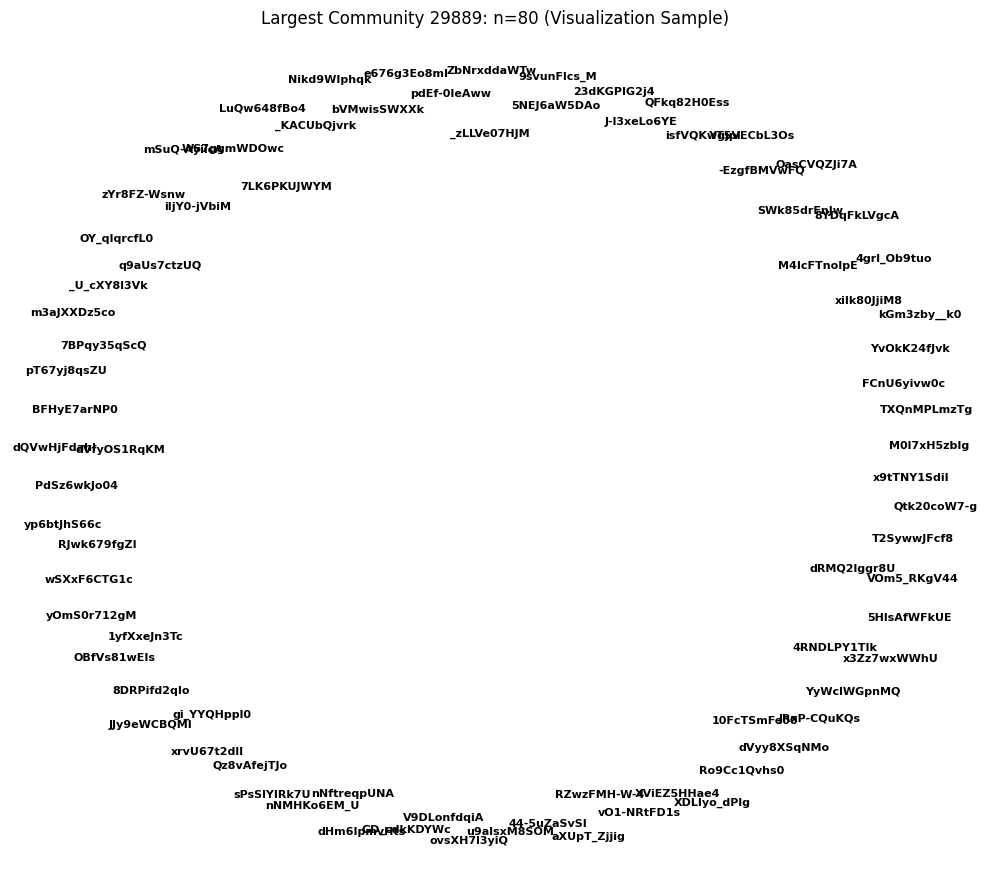

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import random
from collections import Counter

community_sizes = Counter(partition.values())
biggest_comm_id = community_sizes.most_common(1)[0][0]
nodes_in_community = [n for n in G.nodes() if partition[n] == biggest_comm_id]
G_comm = G.subgraph(nodes_in_community).copy()

print(f"Largest community: {biggest_comm_id} with {len(nodes_in_community)} nodes.")


node_limit = 80
if len(G_comm) > node_limit:
    sample_nodes = random.sample(list(G_comm.nodes()), node_limit)
    G_vis = G_comm.subgraph(sample_nodes).copy()
    print(f"Sampled: {node_limit} nodes for plotting (for clarity).")
else:
    G_vis = G_comm

plt.figure(figsize=(10, 9))
pos = nx.spring_layout(G_vis, k=0.24, seed=42)
sizes = [1200 * pagerank_scores[n] for n in G_vis.nodes()]
comm_colors = [partition[n] for n in G_vis.nodes()]
nx.draw_networkx_nodes(G_vis, pos, node_color=comm_colors, node_size=sizes, cmap=plt.cm.tab20, edgecolors='k', alpha=0.9)
nx.draw_networkx_edges(G_vis, pos, alpha=0.25, width=0.85)
nx.draw_networkx_labels(G_vis, pos, font_size=8, font_weight='bold')
plt.title(f"Largest Community {biggest_comm_id}: n={G_vis.number_of_nodes()} (Visualization Sample)")
plt.axis('off')
plt.tight_layout()
plt.show()


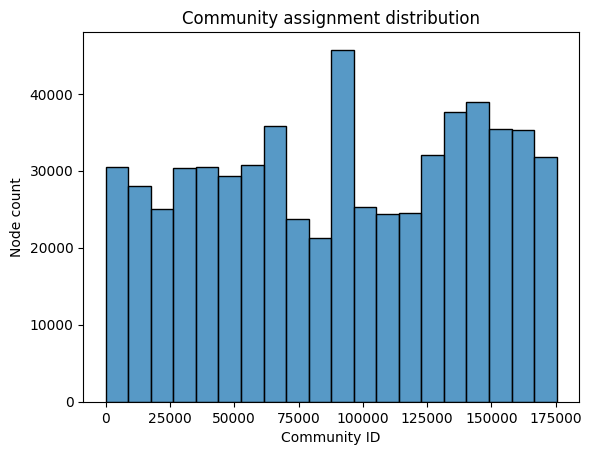

In [ ]:
import seaborn as sns
sns.histplot([partition[n] for n in G.nodes()], bins=20)
plt.title('Community assignment distribution')
plt.xlabel('Community ID')
plt.ylabel('Node count')
plt.show()
